In [ ]:
#Installing Scanpy along with other Single Cell dependencies
%pip install numpy anndata scanpy[skmisc] igraph leidenalg umap-learn muon plotnine harmonypy pydeseq2 pymemesuite  pyupset gprofiler-official psutil pynvml

In [ ]:
import os, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

# Core scverse libraries
import anndata as ad
import scanpy as sc

import seaborn as sns
from scipy.stats import median_abs_deviation

#plotting
from plotnine import (
    ggplot,
    aes,
    scale_x_log10,
    scale_y_log10,
    geom_point,
    geom_violin,
    geom_boxplot,
    geom_jitter,
    theme_matplotlib,
    theme_set,
)
from gprofiler import GProfiler
from typing import List

from scipy.sparse import diags

# Data retrieval
import pooch


#Neural network implementation libraries
import torch
from torch import nn, optim
from torch.nn import functional
import sklearn
import sklearn.metrics as skm

#class weighting for imbalanced datasets from sklearn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix



#RAM-CPU profiling
import psutil
import threading
import pynvml
import time





<h2>Part 0: Downloading the dataset and RAM/CPU measuring function</h2>



In [ ]:
def download_dataset():
  """
  Download and load the single-cell RNA sequencing dataset as an AnnData object.

    Here, a dataset is downloaded from a certain URL, consequetively the dataset is loaded into an AnnData object.
    Input: !wget -c downloadLink -O sameNameAsFile.h5ad
    Returns: adata (AnnData file)
  """
  !wget -c https://datasets.cellxgene.cziscience.com/f4b594d9-1c81-420d-9cac-d9cb7041c921.h5ad  -O human_gland_50k.h5ad
  adata = ad.read_h5ad("human_gland_50k.h5ad")
  return adata

adata = download_dataset()

--2025-03-21 18:52:17--  https://datasets.cellxgene.cziscience.com/f4b594d9-1c81-420d-9cac-d9cb7041c921.h5ad
Resolving datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)... 13.227.219.61, 13.227.219.99, 13.227.219.102, ...
Connecting to datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)|13.227.219.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 257546770 (246M) [binary/octet-stream]
Saving to: ‘human_gland_50k.h5ad’

human_gland_50k.h5a 100%[===================>] 245.62M   179MB/s    in 1.4s    

2025-03-21 18:52:19 (179 MB/s) - ‘human_gland_50k.h5ad’ saved [257546770/257546770]



In [ ]:
#RAM-GPU-CPU profiling
pynvml.nvmlInit()

def GPU_measures():
  """
  Measures the current usage of GPU
  Input: None
  Output: GPU memory usage in Mb
  """
  handle = pynvml.nvmlDeviceGetHandleByIndex(0) #Selects any GPU available
  gpu_usage = pynvml.nvmlDeviceGetUtilizationRates(handle) #Gets the use percentage of the GPU
  gpu_perc = gpu_usage.gpu

  return gpu_perc

training = True #Boolean required for threading the RAM/CPU process
ram_usage, cpu_usage, gpu_usage = [],[],[]

def RAM_CPU_GPU_measures():
  """
  Measures the current use of RAM and CPU every second and stores them in their respective arrays
  Input: None
T  Output: RAM, CPU and GPU usage arrays
  """
  while training:
    time.sleep(1)
    ram_usage.append(psutil.virtual_memory().percent)
    cpu_usage.append(psutil.cpu_percent())
    gpu_usage.append(GPU_measures())

### Ensure Imbalanced Dataset


cell_type
acinar cell of salivary gland           29997
salivary gland glandular cell            3846
fibroblast                               3630
plasma cell                              2979
blood vessel endothelial cell            2205
CD8-positive, alpha-beta T cell          2063
macrophage                               1092
mural cell                                778
neutrophil                                665
CD4-positive helper T cell                657
keratinocyte                              586
Schwann cell                              529
dendritic cell                            331
ionocyte                                  315
myoepithelial cell                        220
natural killer cell                       155
endothelial cell of lymphatic vessel       81
adult skeletal muscle myoblast             56
B cell                                     55
Name: count, dtype: int64
Number of unique cell types: 19


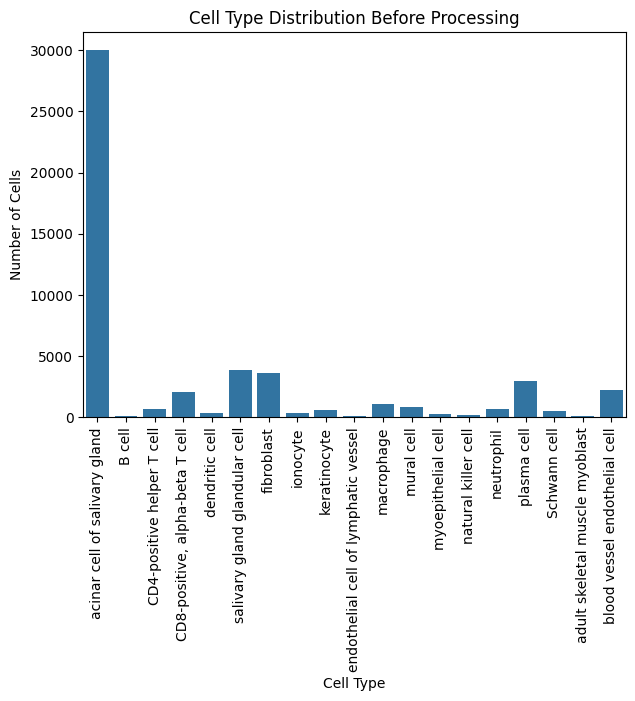

In [ ]:
#asses cell type distribution
cell_counts_before = adata.obs['cell_type'].value_counts()
print(cell_counts_before)

num_cell_types = adata.obs['cell_type'].nunique()
print(f"Number of unique cell types: {num_cell_types}")

def plot_cell_distribution(cell_counts, title="Cell Type Distribution"):
    """
    Plots the distribution of cell types.

    Parameters:
    - cell_counts: Pandas Series containing cell type counts.
    - title: String, title of the plot.
    """
    plt.figure(figsize=(7, 5))
    sns.barplot(x=cell_counts.index, y=cell_counts.values)
    plt.xticks(rotation=90)
    plt.xlabel("Cell Type")
    plt.ylabel("Number of Cells")
    plt.title(title)
    plt.show()

<h2>Part 1: Start Single-cell Preprocessing</h2>

In [ ]:
def preprocessing(adata,min_genes,min_cells,max_perc,min_perc,cut_2k):
  """
  Performs a rutinary (low-expressed genes, outlier removal, normalization and log transformation)
  pre-processing assay to the input data

  Input: AnnData file, minimum of expressing genes, minimum of expressing cells, maximum and minimum quantiles, and
  boolean if only the most variable genes are wanted
  Output: AnnData file with preprocessed data
  """
  prev_dims = adata.shape
  sc.pp.filter_cells(adata, min_genes=min_genes) #Eliminate cells that do not express at least min_genes
  sc.pp.filter_genes(adata, min_cells=min_cells) #Delete genes that are not expressed in at least min_cells

  #Required for quantile calculations
  adata.var["mt"] = adata.var_names.str.startswith("MT-") #Creates an additional column with the variable "MT" (to see if the gene is mitochondrial or not upfront)
  sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], log1p=False, inplace=True) #Calculates metrics

  #Quantile calculations
  up_lim = np.quantile(adata.obs.n_genes_by_counts.values, max_perc)
  low_lim = np.quantile(adata.obs.n_genes_by_counts.values,min_perc)
  adata = adata[(adata.obs.n_genes_by_counts < up_lim) & (adata.obs.n_genes_by_counts > low_lim)] #Deletes genes outside of the quantile range

  #Normalizing and log transforming data
  sc.pp.normalize_total(adata, target_sum = 1e4) #1e4: Normalization standard
  sc.pp.log1p(adata)

  #Taking the n_top_genes most variable genes only
  if cut_2k == True:
    sc.pp.highly_variable_genes(adata, n_top_genes = 2000)
    adata = adata[:,adata.var["highly_variable"]]

  new_dims = adata.shape
  print("Initial dims: {} \nDims after preprocessing: {}".format(prev_dims,new_dims))
  return adata

st = time.time()
adata = preprocessing(adata, min_genes = 200, min_cells = 3, max_perc = 0.95, min_perc = 0.05,cut_2k = False)
print("Preprocessing time: {:.2f} s".format(time.time()-st))

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:208: UserWarning: Received a view of an AnnData. Making a copy.


Initial dims: (50240, 36306) 
Dims after preprocessing: (40385, 25969)
Preprocessing time: 41.23 s


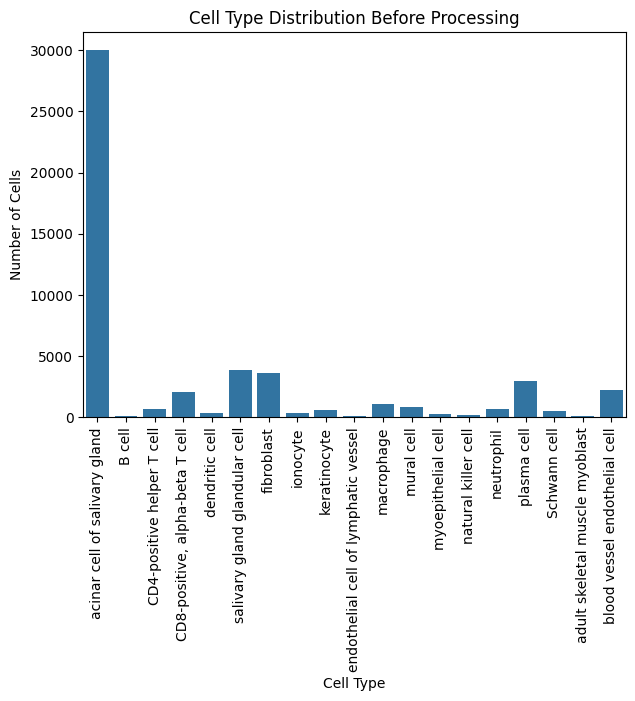

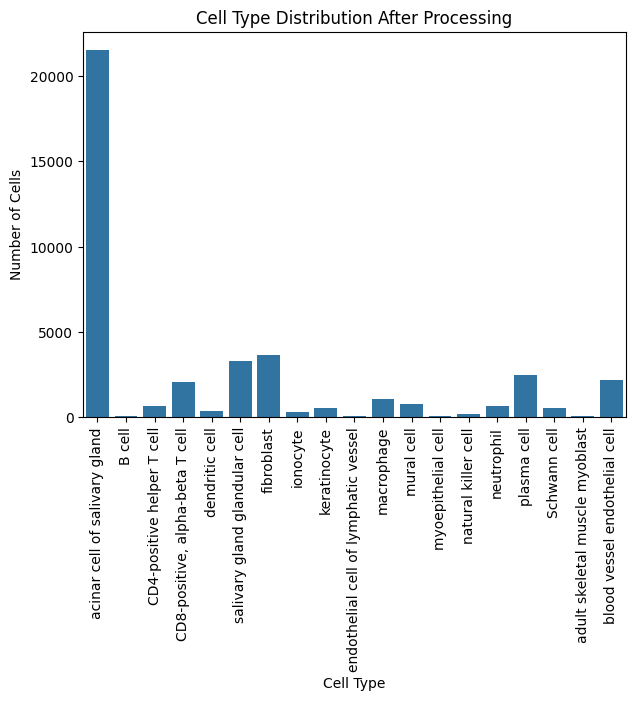

In [ ]:
#asses cell type distribution
cell_counts_after = adata.obs['cell_type'].value_counts()
plot_cell_distribution(cell_counts_before, "Cell Type Distribution Before Processing")
plot_cell_distribution(cell_counts_after, "Cell Type Distribution After Processing")

<h2>Part 2: Data Splitting and Reduction  </h2>

No data reduction.

In [ ]:
#Checking for available device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:",device)

Device: cuda


In [ ]:
#Putting all kinds of seeds for reproducbility.
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

X = adata.X #Input data to our model
#Encoding the labels (giving them a number between 0 and n_types-1)
enc = LabelEncoder()
enc.fit(adata.obs["cell_type"])
y = enc.transform(adata.obs["cell_type"])



#Splitting our data into training and testing (80:20 split)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42, stratify=y) #stratify=y: Fixes class imbalance of the y array (basic method for this)


#RAW_dataset: Converting data into PyTorch tensors
X_train = torch.from_numpy(X_train.todense()).type(torch.float)
X_test = torch.from_numpy(X_test.todense()).type(torch.float)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)


#Put data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

### Visualize Class Distribution of Training Data

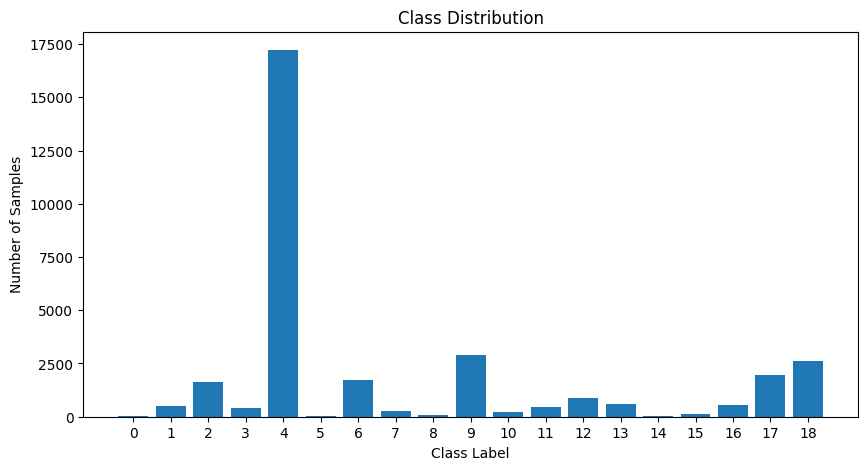

In [ ]:
# Get unique classes and their counts
unique_classes, class_counts = np.unique(y_train.cpu(), return_counts=True)

# Plot the class distribution
plt.figure(figsize=(10, 5))
plt.bar(unique_classes, class_counts, tick_label=unique_classes)
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")
plt.show()

### Class weight Implementation for the Loss Function

Single-cell data has a highly skewed distribution, with some cell types appearing hundreds of times more frequently than others. If we would directly use the raw class weights, some classes will be given extreme importance, which can:
- Destabilize training (huge gradient updates for rare classes).
- Overcompensate rare classes, causing incorrect predictions.
- Hinder generalization, making the model fit too closely to minority classes.

Since deep learning is sensitive to extreme class weight ratios, we need a stable balancing approach that improves performance without overcompensating for rare classes.
We applied square root scaling above on top of computing standard weights because:
- It reduces extreme weights for very rare classes. (Like B cells in this example)
- It still gives more weight to underrepresented cell types without overcompensating.
- It maintains a reasonable class distribution balance for training. stability.

Weights remain in a reasonable range.
The model doesn’t overly favor rare classes.
Training remains stable.

In [ ]:
# Compute standard class weights using integer-encoded labels (loss function parameter for imbalanced datasets)
raw_class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train.cpu().numpy()),
                                     y=y_train.cpu().numpy())
# Apply sqrt scaling to prevent extreme weighting
class_weights = np.sqrt(raw_class_weights)

# Convert to tensor for PyTorch
class_weights = torch.tensor(class_weights, dtype=torch.float32)
class_weights = class_weights.to(device)

In [ ]:
print("Computed class weights:")
for cls, weight in zip(unique_classes, class_weights):
    print(f"Class {cls}: {weight:.4f}")

Computed class weights:
Class 0: 6.2166
Class 1: 1.8014
Class 2: 1.0195
Class 3: 2.0316
Class 4: 0.3142
Class 5: 6.6031
Class 6: 0.9888
Class 7: 2.5379
Class 8: 5.1147
Class 9: 0.7657
Class 10: 2.6618
Class 11: 1.9726
Class 12: 1.4013
Class 13: 1.6548
Class 14: 6.2166
Class 15: 3.7181
Class 16: 1.7912
Class 17: 0.9281
Class 18: 0.8044


<h2>Part 3: Building and training the model</h2>
<ul>
<li><b>Input neurons:</b> Number of columns (genes) in dataset + 1 for bias<br>
<li><b>Hidden layers:</b> 5 (tuned) <br>
<l><b>Neurons per hidden layer:</b> Between 10-512 (or mean between input and output sizes)
<li><b>Output neurons:</b> One per class (~10-50)
</ul>

References: <a href = "https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw">This StackExchange post</a> and <a href = "https://www.learnpytorch.io/02_pytorch_classification/"> this tutorial</a> (chapter 8.2)


In [ ]:
X_train.shape

torch.Size([32308, 25969])

In [ ]:
#Building the model
class Cell_Pred_Model(nn.Module):

  def __init__(self,input_size,hidden_size,output_size, n_layers):
    """
    Builds the basis for a neural network composed of an input layer, multiple hidden layers and an output layer
    (multi-layer perceptron).

    Arguments:
        input_size: Number of input neurons (number of genes)
        hidden_size: Number of neurons per hidden layer
        output_size: Number of output neurons (number of cell types = our classes)
        n_layers: Number of hidden layers (4 by default)

    Returns:
    Pass of X through the model
    """
    super().__init__()
    self.i_layer = nn.Linear(input_size,hidden_size) #Input layer
    ##nn.ReLU()
    self.h_layers = nn.ModuleList([nn.Linear(hidden_size,hidden_size) for i in range(n_layers)]) #Hidden layers
    ##nn.ReLU()
    self.o_layer = nn.Linear(hidden_size,output_size) #Output layer

  #the forward method defines computation in the model
  def forward(self,x):
    x = self.i_layer(x) #Pass through input layer
    x = nn.ReLU()(x) #activation function

    for layer in self.h_layers: #Pass through hidden layers
      x = layer(x)
      x = nn.ReLU()(x)

    x = self.o_layer(x) #Final prediction
    return x

#Create an instance of CellType prediction Model and send it to the target device
model_0 = Cell_Pred_Model(input_size = X_train.size()[1],hidden_size = 128,
                        output_size = len(np.unique(y)),n_layers = 5).to(device)

In [ ]:
model_0 #, model_0.state_dict()

Cell_Pred_Model(
  (i_layer): Linear(in_features=25969, out_features=128, bias=True)
  (h_layers): ModuleList(
    (0-4): 5 x Linear(in_features=128, out_features=128, bias=True)
  )
  (o_layer): Linear(in_features=128, out_features=19, bias=True)
)

In [ ]:
X_test.device

device(type='cuda', index=0)

# 3.2 Set up the criterion (aka loss_fn) and optimizer


In [ ]:
torch.manual_seed(42)
#Set up the Loss function
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
"""
 measures the error between predictions and ground truths
the basic loss choice for multiclass classification problems

Arguments:

weight: should be a 1D tensor assigning weight to each of the classes, this is particularly useful
        for when you have unbalanced training set
"""

#Set up the optimizer
optimizer = torch.optim.Adam(params=model_0.parameters(),   #updates the model parameters accordingly
                           lr= 0.001)

### 3.3 Accuracy
Out of 100 examples what percentage does our model get right?

In [ ]:
#Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

# 3.4 Training the model

In [ ]:
#Create empty loss lists to track values
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []


def  model_training(epochs):
    """
    Trains the fully connected NN model and evaluates performance on test set
    """
    #Setting seed for reproducible results
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    model_0.train()

    #loop through the data
    for epoch in range(epochs):
    ###Training

        y_logits = model_0(X_train)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

        loss = loss_fn(y_logits, y_train)

        #Calculate any metrics here
        acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

        optimizer.zero_grad()

        #Backward pass
        loss.backward()
        optimizer.step()

        # Track training loss and accuracy
        train_losses.append(loss.item())
        train_accuracies.append(acc)

        ###Testing
        model_0.eval()
        with torch.inference_mode():

            test_logits = model_0(X_test)
            test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_test, test_preds)


            # Track test loss and accuracy
            test_losses.append(test_loss.item())
            test_accuracies.append(test_acc)

        #Print out whats happening.
        if epoch % 50 == 0:
            print(f"Epoch: {epoch}| Loss:{loss:.4f}, Acc:{acc:.2f}, | Test loss: {test_loss:.4f}, Test acc:{test_acc:.2f}%")

    print("Runtime: {:.3f} s".format(time.time()-st))

In [ ]:
# Start tracking before training
st = time.time()
training = True
tracking_thread = threading.Thread(target=RAM_CPU_GPU_measures)
tracking_thread.start()

# Run training
model_training(epochs=500)

# Ensure logs are saved before exiting
training = False
tracking_thread.join()  # Wait for tracking to finish

Epoch: 0| Loss:2.9446, Acc:1.62, | Test loss: 2.9351, Test acc:2.19%
Epoch: 50| Loss:0.4102, Acc:91.83, | Test loss: 0.7917, Test acc:83.16%
Epoch: 100| Loss:0.0343, Acc:99.24, | Test loss: 1.2461, Test acc:88.30%
Epoch: 150| Loss:0.0020, Acc:99.99, | Test loss: 1.7066, Test acc:88.10%
Epoch: 200| Loss:0.0005, Acc:100.00, | Test loss: 1.9729, Test acc:88.13%
Epoch: 250| Loss:0.0002, Acc:100.00, | Test loss: 2.2183, Test acc:88.08%
Epoch: 300| Loss:0.0001, Acc:100.00, | Test loss: 2.4108, Test acc:88.08%
Epoch: 350| Loss:0.0000, Acc:100.00, | Test loss: 2.5611, Test acc:88.05%
Epoch: 400| Loss:0.0000, Acc:100.00, | Test loss: 2.6978, Test acc:88.06%
Epoch: 450| Loss:0.0000, Acc:100.00, | Test loss: 2.8307, Test acc:88.02%
Runtime: 61.853 s


<h2>Part 4: Evaluate Model & Compute Metrics</h2>

In [ ]:
model_0.eval()
with torch.inference_mode():
    test_logits = model_0(X_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

#Compute metrics
conf = skm.confusion_matrix(y_test.cpu(),test_preds.cpu())
acc = skm.accuracy_score(y_test.cpu(), test_preds.cpu())
f1 = skm.f1_score(y_test.cpu(), test_preds.cpu(), average="weighted")


print("\n=== Model Evaluation ===")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")


=== Model Evaluation ===
Accuracy: 0.8808
F1 Score: 0.8770


In [ ]:
print(acc)
print(f1)

0.8807725640708184
0.877026842210747


In [ ]:
method = "raw"  # Since the model was trained on the reduced dataset (not full data set or Rand. Under-sampled)
filename = "cm_DNN_{}x{}_{}.csv".format(X.shape[0], X.shape[1], method)
np.savetxt(filename, conf, delimiter=",", fmt="%d")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Storing all usage metrics in a .csv dataset
metrics = {"cpu":cpu_usage, "ram": ram_usage, "gpu": gpu_usage, "acc": acc, "f1": f1, "time (s)": len(gpu_usage)}
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("comp_metrics_DNN_{}x{}_{}.csv".format(X.shape[0],X.shape[1],method))

## Final: Evaluation of Predictions and Visualization of Computational Metrics



In [ ]:
test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
print(f"Predictions: test_preds={test_preds[:10]}\nLabels:{y_test[:10]}")
print(f"Test accuracy: {acc:.2f}")

Predictions: test_preds=tensor([ 4,  4,  4,  4,  4, 18,  9,  4, 16,  2], device='cuda:0')
Labels:tensor([18, 11,  4,  4,  4,  4,  9,  4, 16,  2], device='cuda:0')
Test accuracy: 0.88


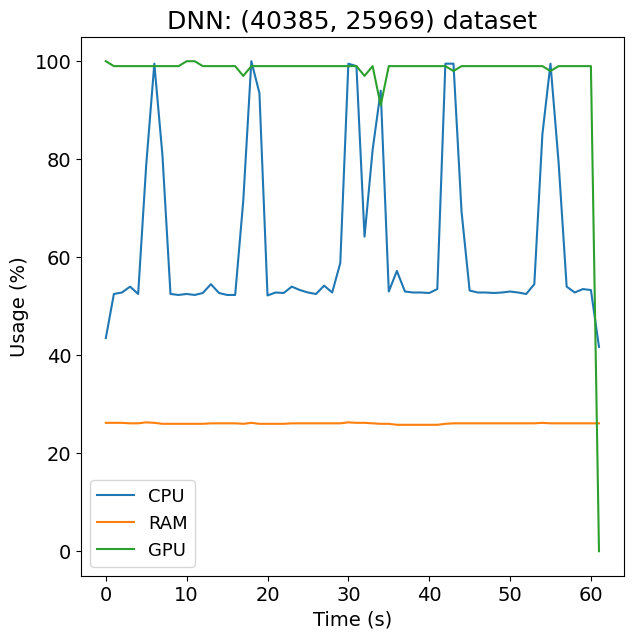

In [ ]:
plt.figure(figsize=(7,7))
plt.title("DNN: {} dataset".format(X.shape),fontsize=18)
plt.plot(cpu_usage,label="CPU")
plt.plot(ram_usage,label="RAM")
plt.plot(gpu_usage,label="GPU")
plt.xlabel("Time (s)",fontsize = 14)
plt.xticks(fontsize = 14)
plt.ylabel("Usage (%)",fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 13)
plt.show()